# Part 2: TF-IDF to understand genres and communities

> Explain the concept of TF-IDF in your own words and how it can help you understand the genres and communities.

### TF-IDF

TF-IDF, or Term Frequency–Inverse Document Frequency, is a technique used in information retrieval. With TF-IDF, one can assess the importance of a word in a specific document compared to a larger collection of documents, or corpus. Here, the importance of words can be explained as their frequent  occurance in a specific document while they are observed less in other documents. Therefore, TF-IDF helps to distinguish documents by highlighting these key words.

### Components of TF-IDF

* **Term Frequency (TF):** TF measures how frequent a word is in a document.

* **Inverse Document Frequency (IDF):** IDF measures how frequent a word is across all documents in the corpus.

Combining these two component, the TF-IDF score for a term $ t $ in a document $ d $ is calculated as:

$$
\text{TF-IDF}_{t,d} = \text{TF}_{t,d} \times \text{IDF}_t
$$

With this calculation, a measure that shows how frequent a word within a document and how distinctive it is across all documents in the corpus can be obtained. A high TF-IDF score indicates that term $t$ is frequent in document $d$, while it is not seen that frequently in other documents. On the other hand, a low TF-IDF score means either the term is not frequent in the document or it is not rare in other documents.

### How TF-IDF can help us understand the genres and communities?

Genres generally has their own cultural background, a theme commonly used in music, or set of instruments that are preferred. TF-IDF scores of the words can help us understand more about the genre since it is likely for terms with large TF-IDF scores to define the genre or maybe even be specific for it.

Similar to genres, TF-IDF scores of the terms can help us distinguish communities, too. The reason why is communities are formed around a topic, a theme, a common influence, or maybe a common belief. Understanding significant terms for a community tell us about unique characteristics of the community.

In [24]:
import networkx as nx
import json
from collections import defaultdict, Counter
import community as community_louvain 
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
import networkx as nx
import numpy as np
import pandas as pd
from wordcloud import WordCloud
import math
import re
import os
import json
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import nltk

In [25]:

# Set random seeds for reproducibility
random.seed(42)
nx.seed = 42

# Load the existing Country Musician network
G = nx.read_graphml(r"/Users/meliscemre/Desktop/2024-2025 Fall/Social Graphs and Interactions/country_musician_graph.graphml")

# Convert to undirected
G = G.to_undirected()

# Remove any self-loops
G.remove_edges_from(nx.selfloop_edges(G))

In [26]:
# Load the JSON file containing genre information
with open('artists_genres_dictionary.json') as f:
    genre_artists_original = json.load(f)

# Normalize function to handle name matching
def normalize_name(name):
    return name.replace("_", " ")

# Apply normalization to artist_genres
normalized_artist_genres = {normalize_name(artist): genres for artist, genres in genre_artists_original.items()}

# Remove nodes that don’t have genre data in the provided dictionary
nodes_to_remove = [node for node in G.nodes if normalize_name(node) not in normalized_artist_genres]
G.remove_nodes_from(nodes_to_remove)
print(f"Removed {len(nodes_to_remove)} nodes without genre data. Remaining nodes: {G.number_of_nodes()}")
print(f"Number of links: {G.number_of_edges()}")

Removed 262 nodes without genre data. Remaining nodes: 1833
Number of links: 14391


In [27]:

# Add genre attribute to remaining nodes
for artist in G.nodes():
    normalized_artist = normalize_name(artist)
    if normalized_artist in normalized_artist_genres and normalized_artist_genres[normalized_artist]:
        # Set genre as the first genre in the list
        G.nodes[artist]['genre'] = normalized_artist_genres[normalized_artist][0]
    else:
        G.nodes[artist]['genre'] = 'Unknown'

# Step 1: Initial community partitioning
# Create a dictionary to store nodes by genre for community detection
community_dict = defaultdict(list)
for node in G.nodes():
    genre = G.nodes[node]['genre']
    community_dict[genre].append(node)

# Convert the community dictionary to a list of sets (for modularity calculation)
communities = [set(nodes) for nodes in community_dict.values()]

# Function to calculate modularity using equation 9.12
def modularity(G, communities):
    L = G.number_of_edges()  # Total number of edges in the network
    modularity_value = 0

    for community in communities:
        L_c = sum(1 for u, v in G.edges() if u in community and v in community)  # Internal edges in community
        k_c = sum(G.degree(n) for n in community)  # Total degree of nodes in community
        modularity_value += (L_c / L) - (k_c / (2 * L)) ** 2

    return modularity_value

# Calculate modularity for the initial genre assignment
initial_modularity = modularity(G, communities)
print("Initial modularity (using the first genre):", initial_modularity)

# Step 2: Modify genre assignment to skip "country" if it's the first genre
for artist in G.nodes():
    normalized_artist = normalize_name(artist)
    if normalized_artist in normalized_artist_genres:
        genres = normalized_artist_genres[normalized_artist]
        # Use the second genre if the first is "country" and there's an alternative
        if genres[0].lower() == 'country' and len(genres) > 1:
            G.nodes[artist]['genre'] = genres[1]
        else:
            G.nodes[artist]['genre'] = genres[0] if genres else 'Unknown'

# Rebuild the communities based on the updated genre assignments
community_dict.clear()
for node in G.nodes():
    genre = G.nodes[node]['genre']
    community_dict[genre].append(node)
communities = [set(nodes) for nodes in community_dict.values()]

# Recalculate modularity for the updated genre assignment
updated_modularity = modularity(G, communities)
print("Updated modularity (skipping 'country' as the first genre):", updated_modularity)

Initial modularity (using the first genre): 0.07174803375172513
Updated modularity (skipping 'country' as the first genre): 0.08542831114272284


Louvain Modularity: 0.3757333364506548


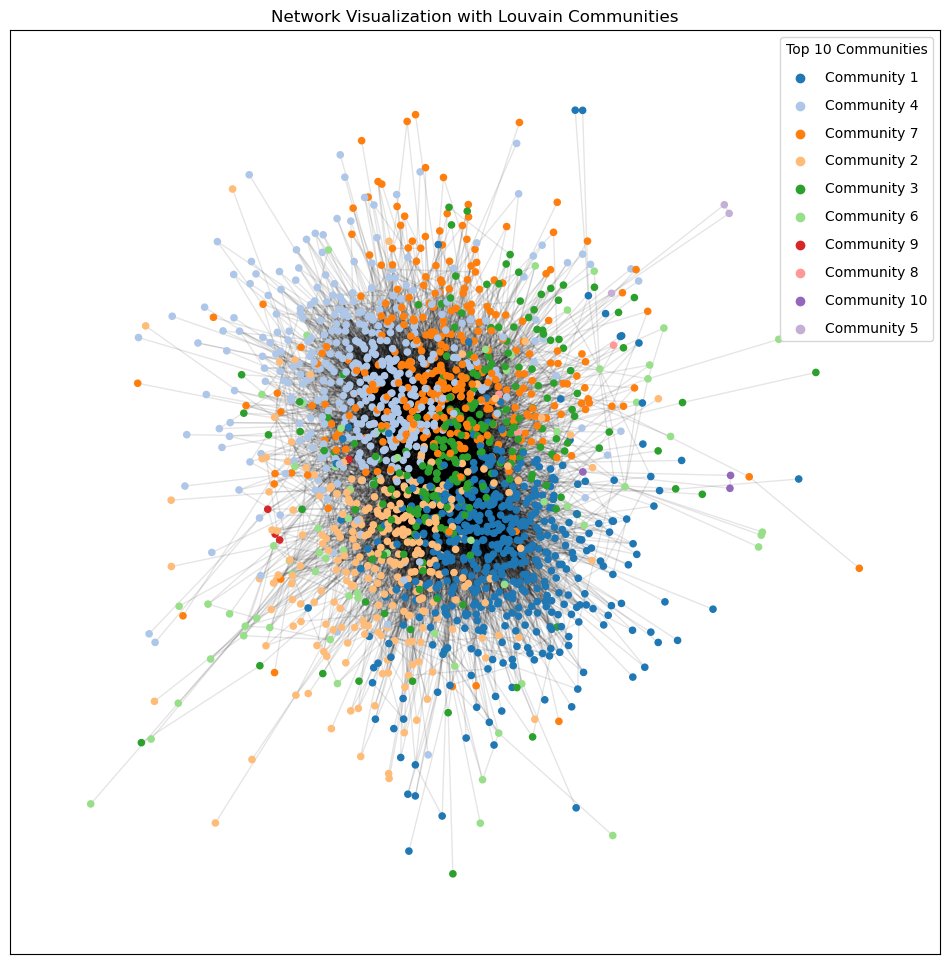

Community Features:
Community 1:
 - Size: 479 nodes
 - Top genres: [('country', 137), ('pop', 33), ('rockabilly', 26)]

Community 4:
 - Size: 436 nodes
 - Top genres: [('country', 229), ('country pop', 60), ('pop', 33)]

Community 7:
 - Size: 323 nodes
 - Top genres: [('country', 206), ('country rock', 18), ('southern rock', 10)]

Community 2:
 - Size: 279 nodes
 - Top genres: [('bluegrass', 56), ('americana', 37), ('country', 30)]

Community 3:
 - Size: 233 nodes
 - Top genres: [('country', 114), ('folk', 17), ('rock', 12)]

Community 6:
 - Size: 67 nodes
 - Top genres: [('country', 40), ('country rock', 4), ('rock', 3)]

Community 9:
 - Size: 4 nodes
 - Top genres: [('neotraditional country', 2), ('country', 2)]

Community 8:
 - Size: 3 nodes
 - Top genres: [('country', 2), ('gospel', 1)]

Community 10:
 - Size: 3 nodes
 - Top genres: [('country', 2), ('rock and roll', 1)]

Community 5:
 - Size: 3 nodes
 - Top genres: [('country', 3)]



In [10]:

# Remove isolated nodes for visualization clarity
G.remove_nodes_from(list(nx.isolates(G)))

# Run Louvain community detection with controlled randomness
partition = community_louvain.best_partition(G, random_state=42)

# Calculate modularity of the Louvain partition
modularity_value = community_louvain.modularity(partition, G)
print(f"Louvain Modularity: {modularity_value}")

# Assign colors to communities for visualization
# Use a colormap with enough colors, but limit to the top 10 communities by size
top_communities = Counter(partition.values()).most_common(10)
community_colors = {community_id: color for community_id, color in zip(
    [comm_id for comm_id, _ in top_communities], plt.cm.tab20.colors)}

# Set a color for each node based on its community, default to gray if not in the top 10
node_colors = [community_colors.get(partition[node], 'lightgray') for node in G.nodes()]

# Use the Force Atlas layout for visualization with a fixed seed
pos = nx.spring_layout(G, seed=42)  # Force Atlas can be approximated by spring layout

# Plot the network with community colors
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, node_size=20, node_color=node_colors)
nx.draw_networkx_edges(G, pos, alpha=0.1)

# Create a legend for the largest communities
for community_id, color in community_colors.items():
    plt.scatter([], [], color=color, label=f'Community {community_id+1}')
plt.legend(scatterpoints=1, frameon=True, labelspacing=1, loc='upper right', title="Top 10 Communities")

plt.title("Network Visualization with Louvain Communities")
plt.show()

# Print community features for the top 10 communities
print("Community Features:")
for community_id, _ in top_communities:
    # Collect nodes in the current community
    community_nodes = [node for node, comm in partition.items() if comm == community_id]
    
    # Calculate size and genres
    size = len(community_nodes)
    genres = [G.nodes[node]['genre'] for node in community_nodes if 'genre' in G.nodes[node]]
    genre_counts = Counter(genres).most_common(3)  # Top 3 genres in the community

    print(f"Community {community_id+1}:")
    print(f" - Size: {size} nodes")
    print(f" - Top genres: {genre_counts}")
    print()


In [12]:

# Assign genres to each node in the graph
for node in G.nodes():
    normalized_node = normalize_name(node)
    if normalized_node in normalized_artist_genres:
        G.nodes[node]['genres'] = normalized_artist_genres[normalized_node]

# Identify the 7 most common genres and 7 largest communities
all_genres = [genre for genres in normalized_artist_genres.values() for genre in genres]
top_genres = [genre for genre, _ in Counter(all_genres).most_common(7)]

# Get the 7 largest communities
top_communities = [community_id for community_id, _ in Counter(partition.values()).most_common(7)]

# Initialize the confusion matrix
confusion_matrix = np.zeros((len(top_genres), len(top_communities)), dtype=int)

# Map genres and communities to indices for the confusion matrix
genre_to_index = {genre: i for i, genre in enumerate(top_genres)}
community_to_index = {community_id: i for i, community_id in enumerate(top_communities)}

# Populate the confusion matrix
for node in G.nodes():
    genres = G.nodes[node].get('genres', [])
    community = partition.get(node)

    # Consider only nodes that are part of top genres and top communities
    if community in top_communities:
        for genre in genres:
            if genre in top_genres:
                i = genre_to_index[genre]
                j = community_to_index[community]
                confusion_matrix[i, j] += 1

# Convert the confusion matrix to a DataFrame for easier interpretation
confusion_df = pd.DataFrame(confusion_matrix, index=top_genres, columns=[f"C{c+1}" for c in top_communities])

print("Confusion Matrix (Genres vs. Communities):")
print(confusion_df)

# Analyze the confusion matrix
for genre in top_genres:
    max_community = confusion_df.loc[genre].idxmax()
    print(f"Genre '{genre}' is most aligned with {max_community} based on node overlap.")


Confusion Matrix (Genres vs. Communities):
               C1   C4   C7   C2   C3  C6  C9
country       406  371  285  160  205  60   2
folk           54   11    2   76   30   5   0
country rock   38   40   33   39   14   5   0
pop            56   54   10   12   21   4   0
americana      21   15    4   82   29   4   1
bluegrass      11    7   18   81   11   0   0
rock           25   20    9   30   25   7   0
Genre 'country' is most aligned with C1 based on node overlap.
Genre 'folk' is most aligned with C2 based on node overlap.
Genre 'country rock' is most aligned with C4 based on node overlap.
Genre 'pop' is most aligned with C1 based on node overlap.
Genre 'americana' is most aligned with C2 based on node overlap.
Genre 'bluegrass' is most aligned with C2 based on node overlap.
Genre 'rock' is most aligned with C2 based on node overlap.


In [13]:
# Define the path to your directory containing the artist text files
text_files_directory = "/Users/meliscemre/Desktop/2024-2025 Fall/Social Graphs and Interactions/wiki_pages"

genre_artists = genre_artists_original

# Dictionary to store aggregated text for each genre
genre_texts = defaultdict(str)

# Assuming `G` is your graph with nodes and `normalize_name` is the function for normalization
# Only include nodes that have a genre associated with them in the graph
normalized_nodes = {normalize_name(node) for node in G.nodes}

# Initialize the artist_texts dictionary
artist_texts = {}

# Function to normalize filenames to match artist names in the graph
def normalize_filename(filename):
    filename = filename.replace(".txt", "")  # Remove the .txt extension
    filename = filename.replace("_", " ")    # Replace underscores with spaces
    return filename

# Iterate through all text files in the directory
for filename in os.listdir(text_files_directory):
    # Normalize the filename to get the artist name
    artist_name = normalize_filename(filename)
    normalized_artist_name = normalize_name(artist_name)

    # Check if the artist exists as a node in the graph
    if normalized_artist_name in normalized_nodes:
        # Read the content of the file
        with open(os.path.join(text_files_directory, filename), 'r', encoding='utf-8') as file:
            artist_texts[normalized_artist_name] = file.read()

# Check the number of artists' texts loaded
print(f"Number of artists' texts loaded: {len(artist_texts)}")


Number of artists' texts loaded: 1827


In [14]:
# Aggregate texts by genre
for artist, genres in genre_artists.items():
    if artist in artist_texts:
        for genre in genres:
            genre_texts[genre] += artist_texts[artist] + " "  # Concatenate text for each genre

# Select top 15 genres by artist count
top_genres = [genre for genre, _ in Counter(all_genres).most_common(15)]

# Filter dictionary to keep only top genres
genre_texts = {genre: text for genre, text in genre_texts.items() if genre in top_genres}

In [15]:

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')


# Set up NLTK tools for text processing
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to process text
def process_text(text):
    # Tokenize and clean text
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]  # Remove punctuation and set to lowercase
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Remove stopwords and lemmatize
    return tokens

# Process text for each genre and build term frequencies
genre_tf = {}
cleaned_genre_texts = {}  # To keep a record of the fully cleaned text for each genre

for genre, text in genre_texts.items():
    tokens = process_text(text)
    cleaned_genre_texts[genre] = ' '.join(tokens)  # Save the cleaned text as a single string
    word_counts = Counter(tokens)
    # Filter out rare words (frequency < 5)
    word_counts = {word: count for word, count in word_counts.items() if count >= 5}
    genre_tf[genre] = word_counts


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/meliscemre/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/meliscemre/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/meliscemre/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/meliscemre/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [18]:
from collections import Counter

# Display the top 15 words for each genre
for genre in top_genres:
    # Get the top words and their frequencies for the genre
    top_words = [(word, count) for word, count in Counter(genre_tf[genre]).most_common()]
    
    # Print results, ensuring we still get up to 15 words excluding 'ref' and 'cite'
    print(f"\nTop 15 words for genre '{genre}', excluding 'ref' and 'cite':")
    for word, count in top_words[:15]:  # Limit to 15 words if more than 15 are left after filtering
        print(f"{word}: {count}")



Top 15 words for genre 'country', excluding 'ref' and 'cite':
ref: 56206
country: 38257
cite: 37851
album: 30760
music: 25690
song: 22492
center: 17772
category: 16768
year: 14913
single: 13370
award: 12708
record: 12691
row: 12366
american: 11283
artist: 9918

Top 15 words for genre 'folk', excluding 'ref' and 'cite':
ref: 11128
cite: 7187
album: 5820
song: 3859
music: 3839
country: 3180
category: 2972
center: 2276
american: 2250
award: 2188
year: 2011
record: 2004
http: 1823
web: 1783
new: 1676

Top 15 words for genre 'country rock', excluding 'ref' and 'cite':
ref: 10034
cite: 7044
album: 6510
country: 5839
music: 4307
song: 3771
band: 3219
award: 2567
year: 2548
category: 2421
released: 1986
single: 1973
american: 1968
rock: 1870
record: 1811

Top 15 words for genre 'pop', excluding 'ref' and 'cite':
ref: 16089
cite: 12277
album: 6450
song: 5333
music: 4752
country: 3778
award: 3579
category: 3332
center: 2831
american: 2636
single: 2616
web: 2577
new: 2569
magazine: 2537
year: 25

In [19]:
top_genres

['country',
 'folk',
 'country rock',
 'pop',
 'americana',
 'bluegrass',
 'rock',
 'country pop',
 'gospel',
 'rockabilly',
 'blues',
 'alternative country',
 'folk rock',
 'southern rock',
 'rock and roll']

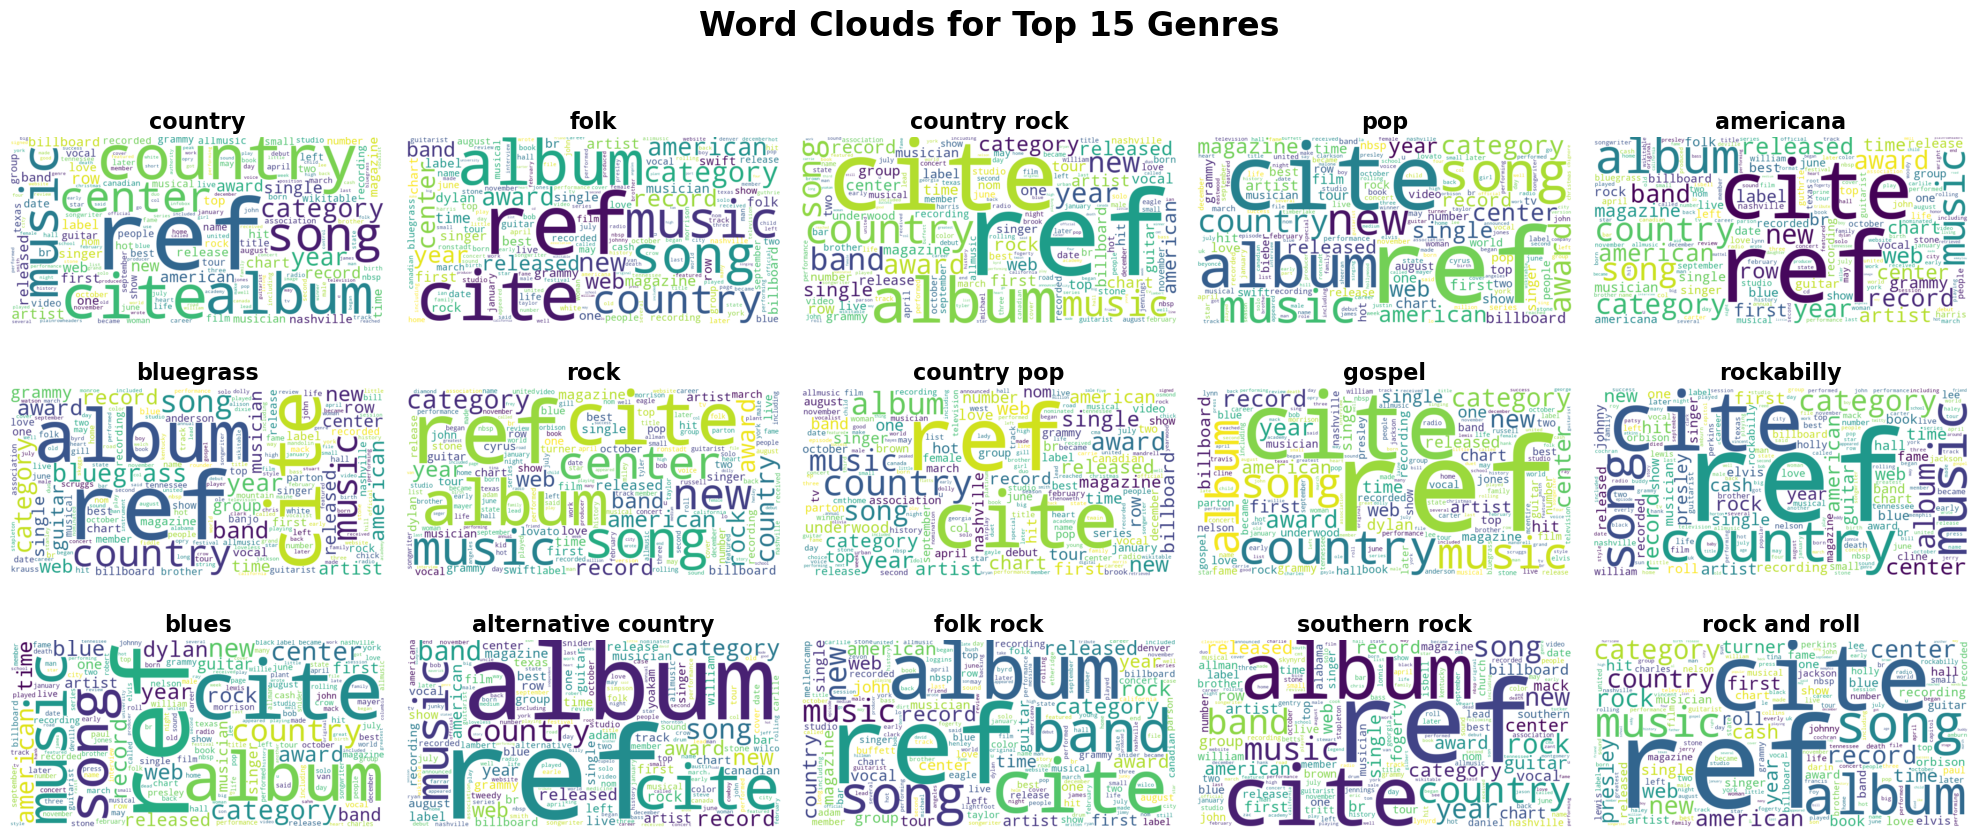

In [20]:

# Function to prepare a single string for word cloud input, excluding unwanted words
def prepare_text_for_wordcloud(word_counts):
    words = []
    for word, count in word_counts.items():
        words.extend([word] * math.ceil(count))
    return ' '.join(words)

# Set up a 3x5 grid for displaying word clouds
fig, axes = plt.subplots(3, 5, figsize=(20, 9))
fig.suptitle("Word Clouds for Top 15 Genres", fontsize=24, fontweight='bold')

# Flatten axes for easy iteration
axes = axes.flatten()

# Generate and plot word clouds for the top 15 genres
for i, genre in enumerate(top_genres):
    if genre not in genre_tf:
        print(f"Warning: '{genre}' not found in genre_tf, skipping...")
        continue

    # Prepare the text for the word cloud, excluding 'ref' and 'cite'
    genre_text = prepare_text_for_wordcloud(genre_tf[genre])

    # Check if the resulting text is empty or contains only redirects
    if not genre_text.strip() or genre_text.startswith('#REDIRECT'):
        print(f"Skipping genre '{genre}' as it has no valid words for word cloud.")
        continue

    # Create the word cloud if there's valid text
    wordcloud = WordCloud(width=800, height=400, collocations=False, background_color='white').generate(genre_text)

    # Plot the word cloud on the grid
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis("off")
    axes[i].set_title(genre, fontsize=16, fontweight='bold')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

# Use tight layout with a smaller pad and adjusted rect to reduce space above the clouds
plt.tight_layout(rect=[0, 0, 1, 0.97], pad=1.5)
plt.show()


Top 10 TF-IDF Words by Genre:
                                      Word #1               Word #2  \
Country                          wick (14.36)      jeffreys (13.97)   
Country Rock                  worsnop (11.08)      blundell (10.77)   
Southern Rock                  sixwire (7.33)       wilkeson (7.02)   
Folk                          tallest (14.13)       matsson (12.63)   
Gospel                  whitburncharts (8.66)        shaddai (7.56)   
Alternative Country          disarmer (10.95)     vanityfair (8.94)   
Pop                                 ü (11.73)      littrell (11.31)   
Bluegrass                         feek (8.58)         cordle (7.84)   
Rock                 allmusichambridge (9.08)      fernandes (8.93)   
Rockabilly                         taz (8.34)       churilla (7.98)   
Rock And Roll                      rwb (7.95)        darlins (7.77)   
Blues                         worsnop (11.08)       shawanda (9.18)   
Country Pop                   dittrich (9.06)  

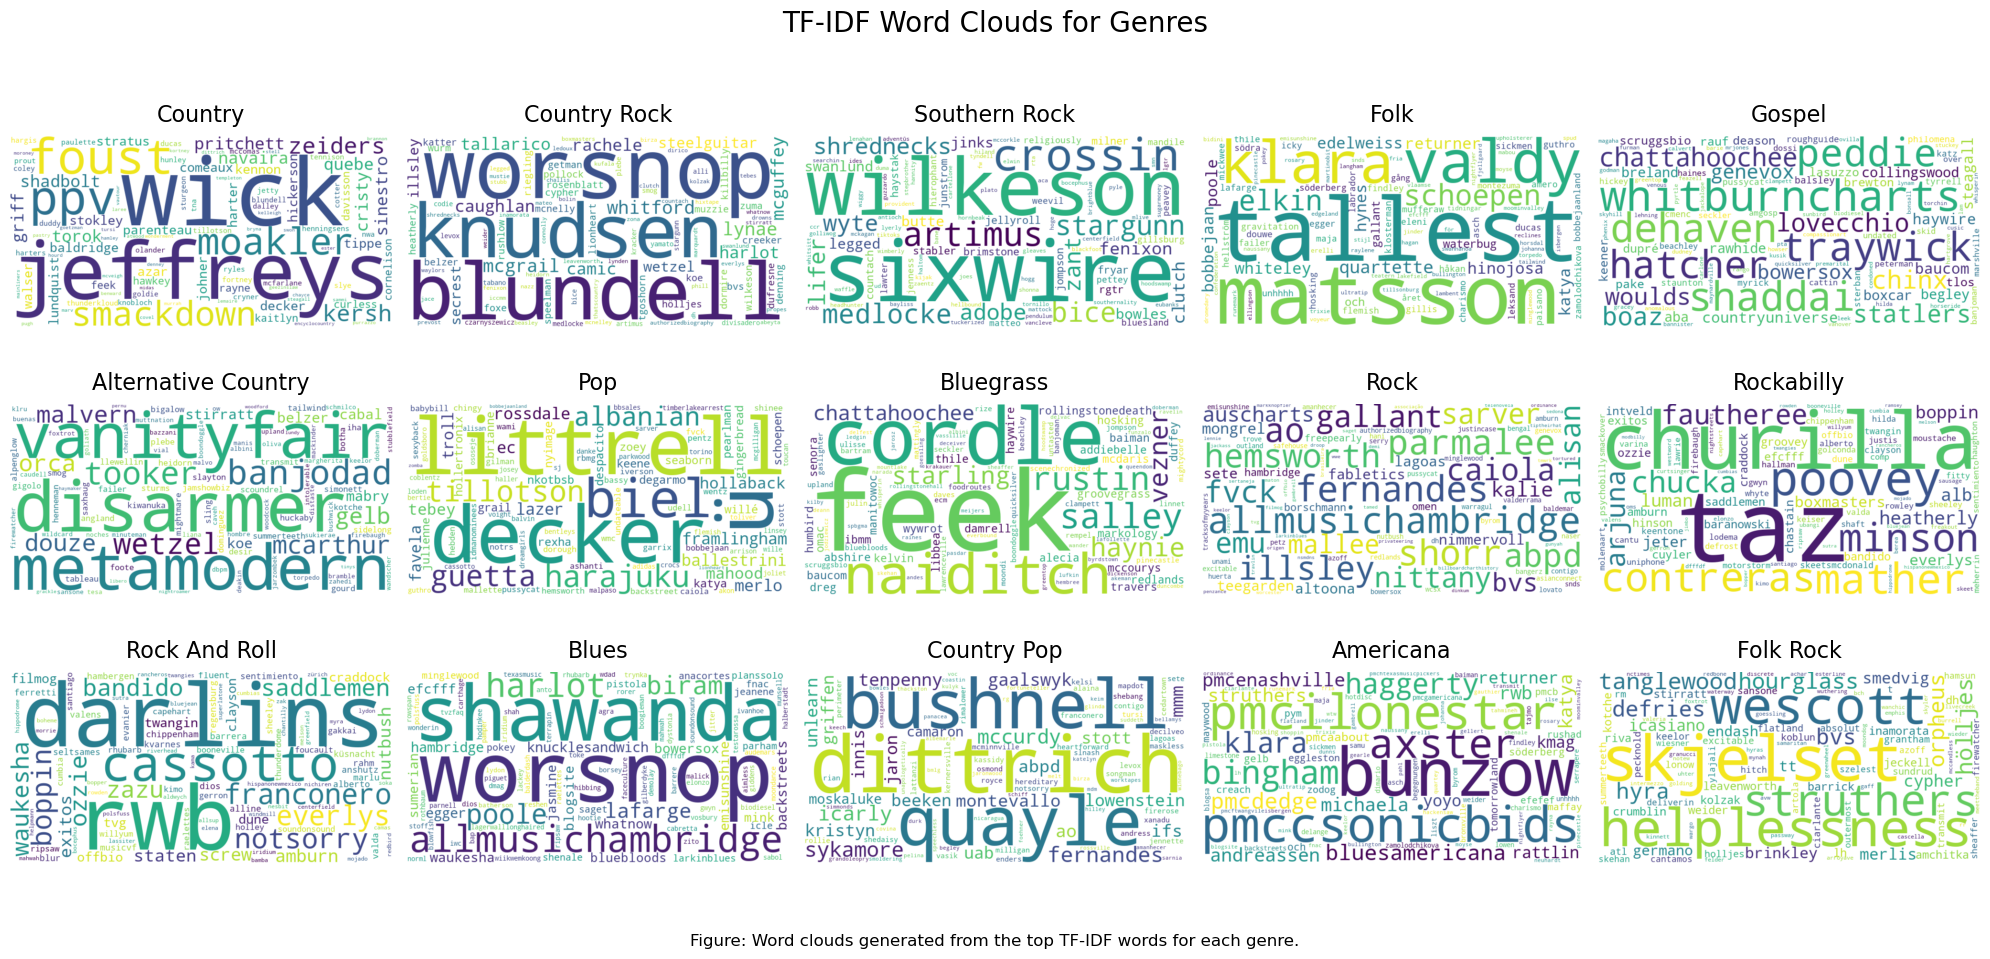

In [35]:
# Calculate TF for each genre
tf_by_genre = {}
for genre, text in cleaned_genre_texts.items():
    word_counts = Counter(text.split())
    tf_by_genre[genre] = {word: 1 + math.log(count) for word, count in word_counts.items()}

# Calculate IDF across all genres
total_documents = len(cleaned_genre_texts)
df_counts = Counter()
for text in cleaned_genre_texts.values():
    unique_words = set(text.split())
    for word in unique_words:
        df_counts[word] += 1

idf = {word: math.log(total_documents / df_count) for word, df_count in df_counts.items()}

# Calculate TF-IDF for each genre
tfidf_by_genre = {}
for genre, tf_values in tf_by_genre.items():
    tfidf_by_genre[genre] = {word: tf * idf[word] for word, tf in tf_values.items()}

# Get top 10 TF-IDF words for each genre
top_words_by_genre = {}
for genre, tfidf in tfidf_by_genre.items():
    sorted_tfidf = sorted(tfidf.items(), key=lambda x: x[1], reverse=True)
    top_words = sorted_tfidf[:10]
    top_words_by_genre[genre] = top_words

# Prepare data for the table
table_data = []
for genre, words in top_words_by_genre.items():
    words = [f"{word} ({score:.2f})" for word, score in words]
    table_data.append(words)

# Create a DataFrame with the top TF-IDF words for each genre
df = pd.DataFrame(table_data, index=[genre.title() for genre in top_words_by_genre],
                  columns=[f"Word #{i+1}" for i in range(10)])

# Display the DataFrame
print("Top 10 TF-IDF Words by Genre:")
print(df)

# Create and display word clouds
num_genres = len(cleaned_genre_texts)
num_cols = 5
num_rows = math.ceil(num_genres / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 3))
axes = axes.flatten()

for idx, (genre, tfidf_scores) in enumerate(tfidf_by_genre.items()):
    ax = axes[idx]
    # Get the top TF-IDF scores for the word cloud
    top_tfidf_scores = dict(sorted(tfidf_scores.items(), key=lambda x: x[1], reverse=True)[:100])
    wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False)
    wordcloud.generate_from_frequencies(top_tfidf_scores)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(genre.title(), fontsize=16, pad=10)

# Hide any empty subplots
for idx in range(len(tfidf_by_genre), len(axes)):
    axes[idx].axis('off')

# Add a main title and caption
fig.suptitle('TF-IDF Word Clouds for Genres', fontsize=20, y=1.02)
caption_text = 'Figure: Word clouds generated from the top TF-IDF words for each genre.'
plt.figtext(0.5, -0.02, caption_text, wrap=True, horizontalalignment='center', fontsize=12)
plt.tight_layout()
plt.show()


Top 10 TF-IDF Words by Community:
                     Word #1             Word #2            Word #3  \
Community 3   beyoncé (6.76)     cbignore (6.09)      avicii (5.90)   
Community 2     valdy (4.12)  emisunshine (3.71)     allison (2.56)   
Community 6  parmalee (3.83)     knobloch (3.19)  overstreet (3.11)   
Community 1     wilco (5.53)       tweedy (4.55)         kot (4.44)   
Community 0  mcdowell (3.11)    firebaugh (2.82)        mead (2.82)   

                      Word #4           Word #5            Word #6  \
Community 3   bergling (5.62)      nelly (5.54)       diplo (5.42)   
Community 2    horsdal (2.56)  contender (2.39)     rushlow (2.25)   
Community 6  bickhardt (3.11)      jypsi (3.03)      rische (3.03)   
Community 1      leahy (4.27)      petty (4.20)   mudcrutch (4.09)   
Community 0   dualtone (2.70)    scruggs (2.70)  rockabilly (2.39)   

                       Word #7         Word #8        Word #9  \
Community 3  marshmello (5.38)    woman (5.18)      d

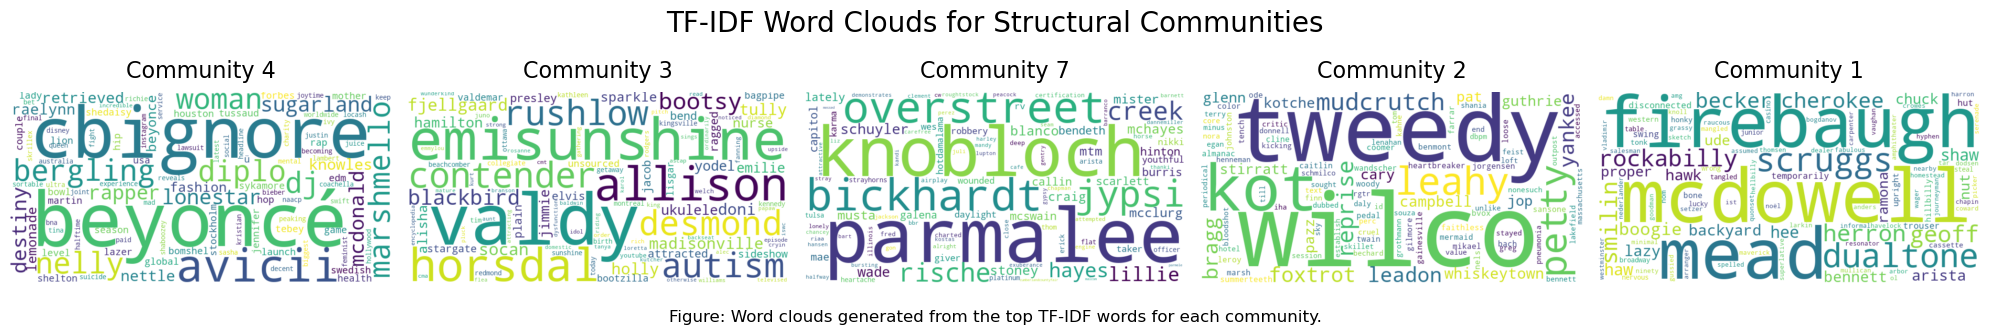

In [34]:
import re
import math
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import defaultdict, Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

# Initialize NLTK tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to clean and preprocess text
def clean_text(text):
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]  # Keep only alphabetic tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Remove stopwords and lemmatize
    return ' '.join(tokens)

# Step 1: Clean the text for each artist
cleaned_artist_texts = {artist: clean_text(text) for artist, text in artist_texts.items()}

# Step 2: Aggregate cleaned text by community
community_texts = defaultdict(str)
for artist, community in partition.items():
    if artist in cleaned_artist_texts:
        community_texts[community] += cleaned_artist_texts[artist] + " "

# Step 3: Calculate TF for each community
tf_by_community = {}
for community, text in community_texts.items():
    word_counts = Counter(text.split())
    tf_by_community[community] = {word: 1 + math.log(count) for word, count in word_counts.items()}

# Step 4: Calculate IDF across all communities
total_communities = len(community_texts)
df_counts = Counter()
for text in community_texts.values():
    unique_words = set(text.split())
    for word in unique_words:
        df_counts[word] += 1

idf = {word: math.log(total_communities / (df_count + 1)) for word, df_count in df_counts.items()}  # Adding 1 to avoid zero division

# Step 5: Calculate TF-IDF for each community
tfidf_by_community = {}
for community, tf_values in tf_by_community.items():
    tfidf_by_community[community] = {word: tf * idf[word] for word, tf in tf_values.items()}

# Step 6: Get top 10 TF-IDF words for each community
top_words_by_community = {}
table_data = []

for community, tfidf in tfidf_by_community.items():
    sorted_tfidf = sorted(tfidf.items(), key=lambda x: x[1], reverse=True)
    top_words = sorted_tfidf[:10]
    top_words_by_community[community] = top_words
    words = [f"{word} ({score:.2f})" for word, score in top_words]
    table_data.append(words)

# Create a DataFrame with the top TF-IDF words for each community
df = pd.DataFrame(table_data, index=[f"Community {c}" for c in top_words_by_community],
                  columns=[f"Word #{i+1}" for i in range(10)])

# Display the DataFrame
print("Top 10 TF-IDF Words by Community:")
print(df)

# Step 7: Create and display word clouds for each community
num_communities = len(community_texts)
num_cols = 5
num_rows = math.ceil(num_communities / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 3))
axes = axes.flatten()

for idx, (community, tfidf_scores) in enumerate(tfidf_by_community.items()):
    ax = axes[idx]
    # Get the top TF-IDF scores for the word cloud
    top_tfidf_scores = dict(sorted(tfidf_scores.items(), key=lambda x: x[1], reverse=True)[:100])
    wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False)
    wordcloud.generate_from_frequencies(top_tfidf_scores)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f"Community {community+1}", fontsize=16, pad=10)

# Hide any empty subplots
for idx in range(len(tfidf_by_community), len(axes)):
    axes[idx].axis('off')

# Add a main title and caption
fig.suptitle('TF-IDF Word Clouds for Structural Communities', fontsize=20, y=1.02)
caption_text = 'Figure: Word clouds generated from the top TF-IDF words for each community.'
plt.figtext(0.5, -0.02, caption_text, wrap=True, horizontalalignment='center', fontsize=12)
plt.tight_layout()
plt.show()
